# Measure simulated sources PSF and vignetting

In [16]:
import os
import glob 

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import QTable
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

from photutils import SkyCircularAperture, aperture_photometry


from scipy.interpolate import LinearNDInterpolator
from astropy.modeling import models, fitting

from regions import CircleSkyRegion

# home = os.path.expanduser('~')

In [17]:
def get_vignetting(instrument,energy,theta,phi,vidir=None):
    #
    # get the pre-calculated vignetting factor for input energy, off-axis and azimuth
    #
    # Using scipy.intepolate.NearestNDInterpolator
    #
    # energy is in eV
    # theta is the off-axis angle in arcsec
    # phi is the azimuth angle in degrees
    #
    if (vidir == None):
        vidir = os.getcwd()
        #vidir = os.path.expanduser('~') + '/XMM/vignetting'
    ffile = f"{vidir}/{instrument}_vignetting_table.fits"
    if (not os.path.isfile(ffile)):
        print ("File with the pre-calculated vignetting function for energy, off-axis and azimuth not found")
        print ("I am looking for a file here:",ffile)
        return None
    vtab = QTable.read(ffile)
    #try:
    #inter = NearestNDInterpolator((vtab['Energy'], vtab['Theta'], vtab['Phi']), vtab['Vig'])
    inter = LinearNDInterpolator((vtab['Energy'], vtab['Theta'], vtab['Phi']), vtab['Vig'])
    result = inter(energy,theta,phi)
    #except:
    #    print (f"Cannot perform the interpolation for (energy,theta,phi) = ({energy},{theta},{phi})")
    #    result = None
    return result

In [18]:
def tie_sigmas(model):
    return model.x_stddev

In [19]:
def fit_source(image,wcs,region,box=5,plot_it=True,verbose=True):
    #
    #
    #
    qwcs = wcs.deepcopy()
    qwcs.wcs.crpix += 1
    reg_pix = region.to_pixel(qwcs)
    center = reg_pix.center
    xshape = image.shape
    col0 = max(int(center.x - box/2.0),0)
    col1 = min(int(center.x + box/2.0),xshape[0])
    row0 = max(int(center.y - box/2.0),0)
    row1 = min(int(center.y + box/2.0),xshape[1])
    #col0 = max(int(center.x - box/2.0 + 1.0),0)
    #col1 = min(int(center.x + box/2.0 + 1.0),xshape[0])
    #row0 = max(int(center.y - box/2.0 + 1.0),0)
    #row1 = min(int(center.y + box/2.0 + 1.0),xshape[1])
    #
    wimage = image[row0:row1,col0:col1]
    wshape = wimage.shape
    if (wshape[0] != box or wshape[1] != box):
        if (verbose):
            print (f'Not performing a fit as the cropped area is not {box}x{box} size (outside image?).')
        return None
    #
    # circular Gaussian (sigma_x = sigma_y)
    #
    #p_init = models.Gaussian2D(amplitude=20.0,x_mean=wshape[0]/2.0,y_mean=wshape[1]/2.0,
    #                           theta=0.0,x_stddev=1.1,y_stddev=1.1,
    #                          bounds={'amplitude': (1,100), 'x_mean': (1.0,box-1.0),'y_mean': (1.0,box-1.0)},
    #                          tied={'y_stddev': tie_sigmas})
    #
    # elliptical Gaussian
    p_init = models.Gaussian2D(amplitude=20.0,x_mean=wshape[0]/2.0,y_mean=wshape[1]/2.0,
                               theta=0.0,x_stddev=1.1,y_stddev=1.1,
                              bounds={'amplitude': (1,100), 'x_mean': (1.0,box-1.0),'y_mean': (1.0,box-1.0)})
    #
    y, x = np.mgrid[:wshape[0], :wshape[1]]
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, y, x, wimage)
    #
    if (plot_it):
        # Plot the data with the best-fit model
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        norm = simple_norm(wimage, 'linear')
        plt.imshow(wimage, origin='lower', interpolation='nearest', norm=norm)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        model = p(x,y)
        norm = simple_norm(model, 'linear')
        plt.imshow(model, origin='lower', interpolation='nearest', norm=norm)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        residual = wimage - model
        norm = simple_norm(residual, 'linear')
        plt.imshow(residual, origin='lower', interpolation='nearest', norm=norm)
        plt.title("Residual")
    return p


In [20]:
def measure_counts(image,wcs,region):
    #
    #
    #
    xap = SkyCircularAperture(region.center,region.radius)
    photo = aperture_photometry(image, xap, wcs=wcs)
    return photo['aperture_sum'][0]


In [21]:
def check_grid_sources(filein,reg_src,vtb,png_name=None):
    #
    #
    # read the empirical vignetting and extract the curves at the two limiting energies
    offs = np.linspace(0.0,900.0,20)
    xv1 = get_vignetting('pn',500.0,offs,0.0,vidir=vtb)
    xv2 = get_vignetting('pn',2000.0,offs,0.0,vidir=vtb)
    #
    # read th einput image
    with fits.open(filein) as hdu:
        wcs1 = WCS(hdu[0].header)
        image1 = hdu[0].data
    #
    #
    bname = os.path.basename(filein)
    #
    centre = reg_src[0].center
    #
    sigma_x = []
    sigma_y = []
    off = []
    counts = []
    for i,x in enumerate(reg_src):
        #print (f'Doind source {i}')
        a = fit_source(image1,wcs1,x,box=7,plot_it=False,verbose=False)
        if (a is None):
            continue
        sigma_x.append(a.x_stddev.value)
        sigma_y.append(a.y_stddev.value)
        dist = centre.separation(x.center)
        off.append(dist.arcmin)
        #
        # now aperture photometry to measure th ecounts within radius
        #
        cs = measure_counts(image1,wcs1,x)
        counts.append(cs)
        #
    t = QTable((off,counts,np.sqrt(counts),sigma_x,sigma_y),names=['off','counts','counts_err','sig_x','sig_y'])
    t.sort('off')
    mask = t['counts'] > 0
    t = t[mask]
    #
    fig, ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
    #ax.scatter(off,amp/amp[0])
    norm0 = t['counts'][0]
    ax[0].errorbar(t['off'],t['counts']/norm0,yerr=t['counts_err']/norm0,fmt='o')
    ax[0].plot(offs/60.0,xv1,color='red',lw=3,label='0.5 keV')
    ax[0].plot(offs/60.0,xv2,color='green',lw=3,label='2 keV')
    ax[0].set_ylabel('Normalised counts')
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title(bname)
    #
    # plot sigmas
    #
    comb = np.sqrt(t['sig_x']**2 + t['sig_y']**2)
    comb = comb/comb[0]
    ax[1].plot(t['off'],comb,'ro-',label=r'$\sqrt{\sigma_x^2 + \sigma_y^2}$')
    ax[1].set_xlabel('Off-axis (arcmin)')
    ax[1].set_ylabel('Normalised (pix)')
    ax[1].set_xlim((0.0,15.0))
    ax[1].grid()
    ax[1].legend()
    if (png_name is not None):
        plt.savefig(png_name,dpi=100)
        plt.show()
        plt.close();
    return t

In [22]:
#
# read the empirical vignetting
#
vtb = '.'#"pn_vignetting_table.fits" #f"{home}/Dropbox/Work/XMM/vignetting"
wdir = '/home/sam/Documents/ESA/data/sim'

In [23]:
#
# read the input positions from a SIMPUT file
#
# read the sources
#
src = QTable.read(f'{wdir}/simput/test_grid/test_grid_f_1e-13_step_10.simput.gz',hdu=1)
#
sources = SkyCoord(src['RA'],src['DEC'],unit=u.deg,frame='icrs')
reg = []
radius = 20.0*u.arcsec
for j in sources:
    reg.append(CircleSkyRegion(j,radius=radius))


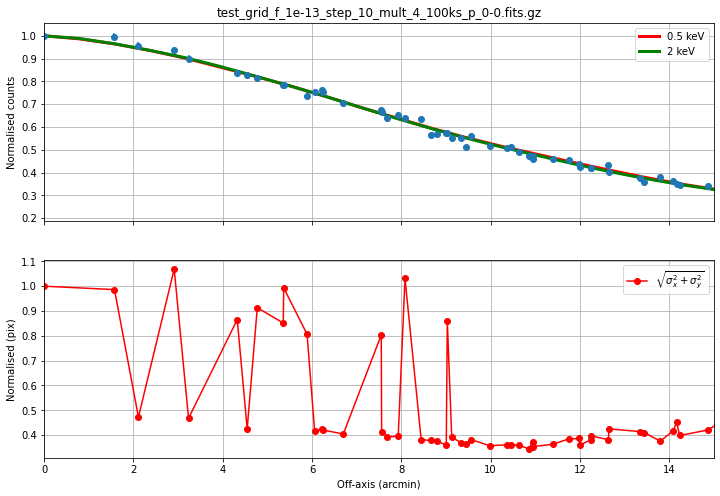

In [14]:
#
# new files, 22 Jul 2021
#
expo = "100ks"
mag = "4x"
#
fname = glob.glob(f'{wdir}/dev2_dataset/{expo}/test_grid/{mag}/*.fits.gz')
#fname = f'{wdir}/{expo}/test_grid/{mag}/test_grid_f_1e-13_step_10_mult_1_50ks_p_0-1.fits.gz'
#
for i in range(len(fname)):
# i = 1
    bname = os.path.basename(fname[i])
    #
    # png = f'{wdir}/{os.path.splitext(bname)[0]}.png'
    png = f'{os.path.splitext(bname)[0]}.png'
    t = check_grid_sources(fname[i],reg,vtb,png)


In [31]:
png

'test_grid_f_1e-13_step_10_mult_4_100ks_p_0-0.fits.png'

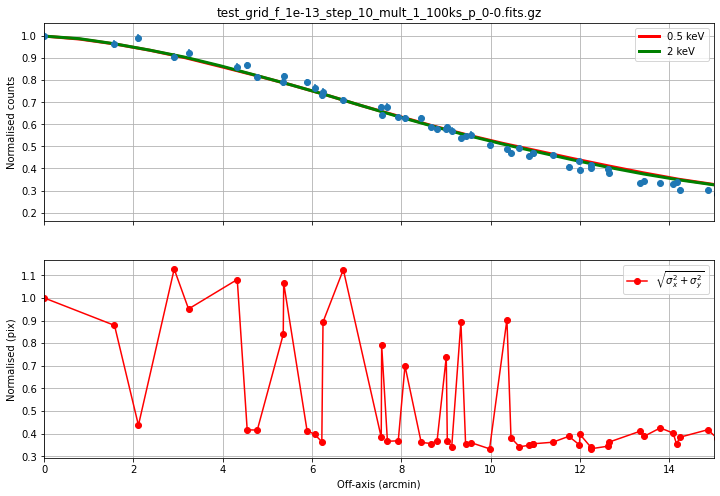

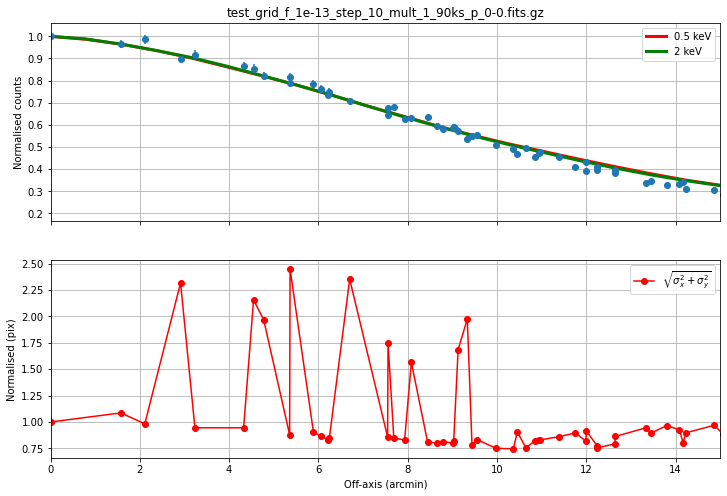

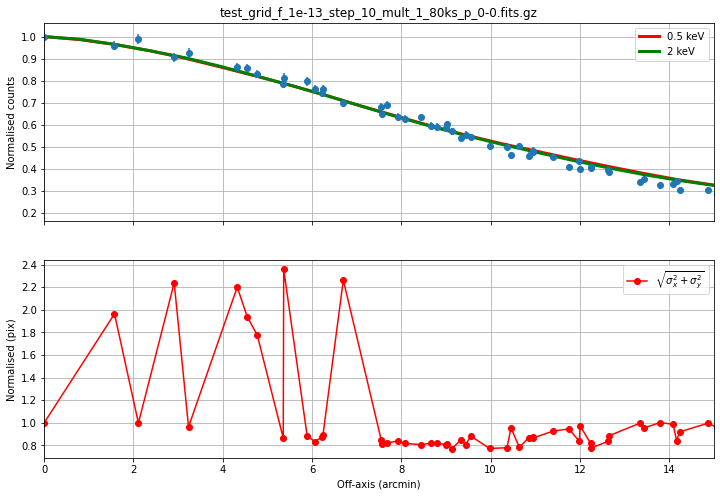

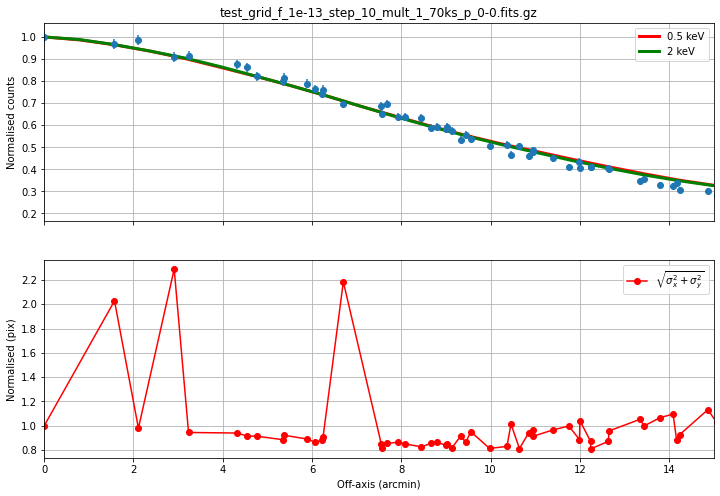

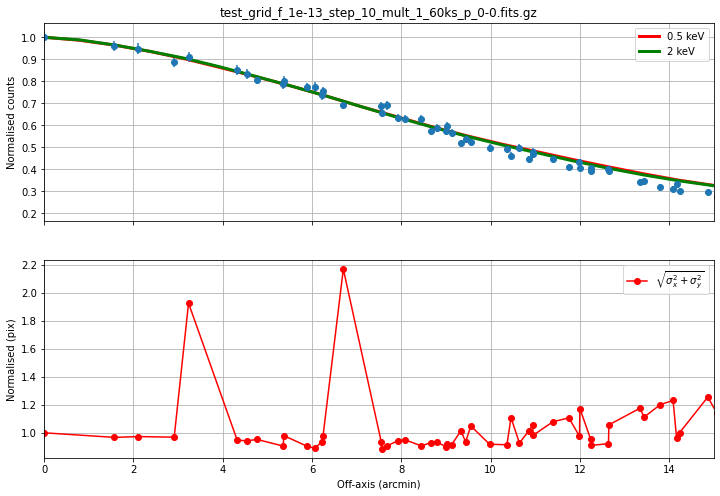

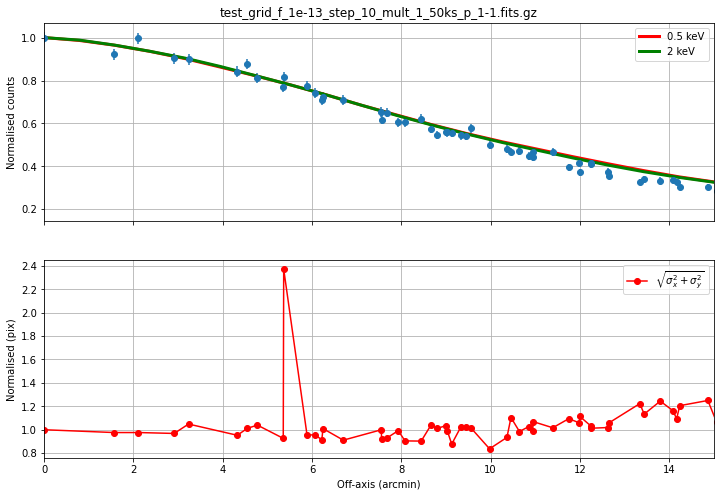

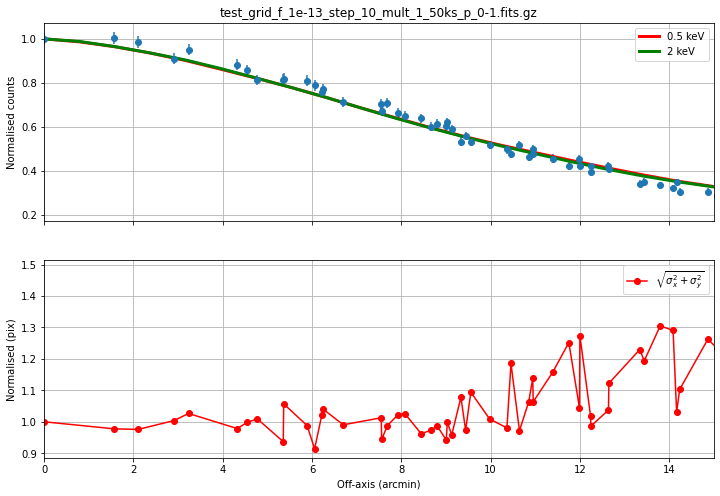

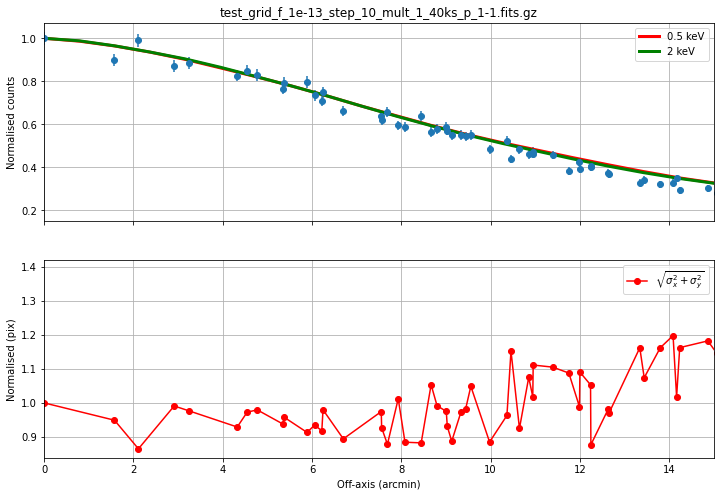

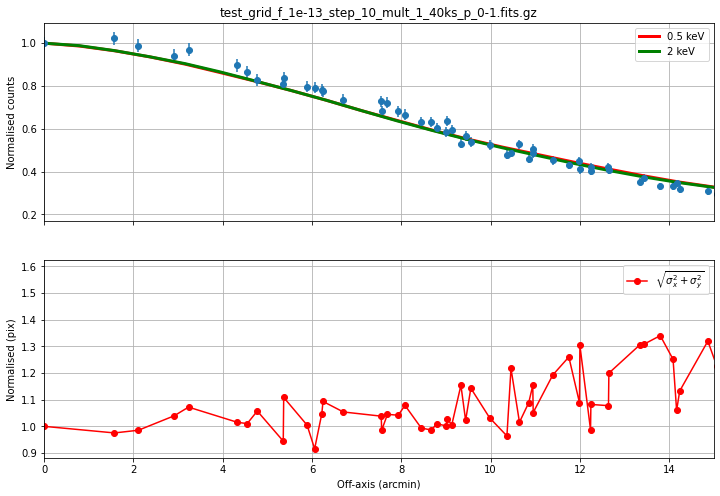

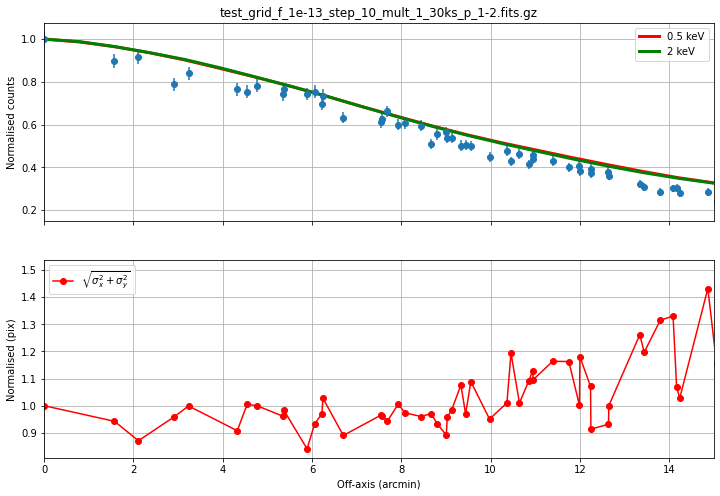

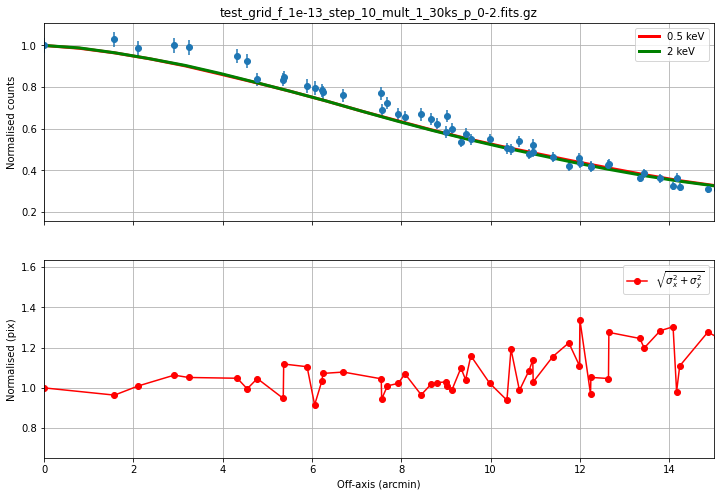

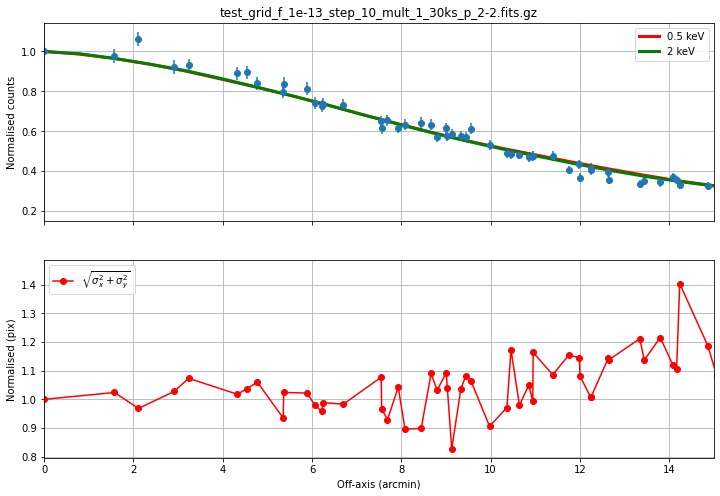

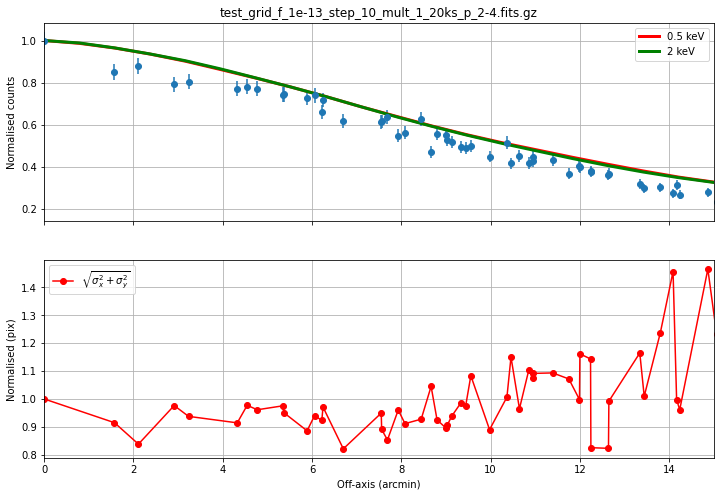

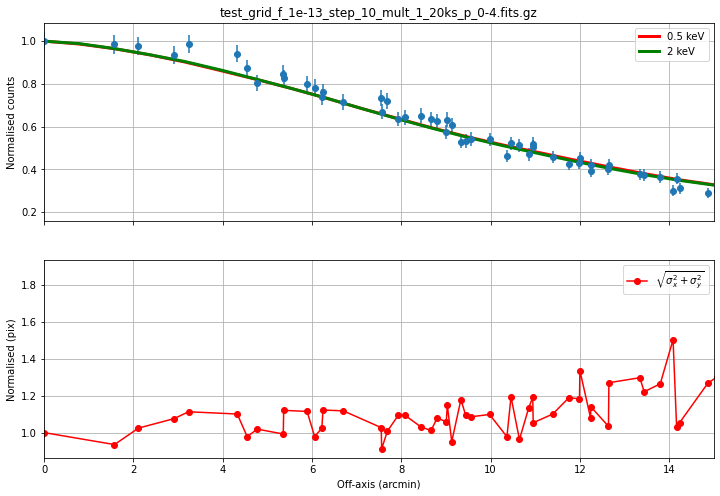

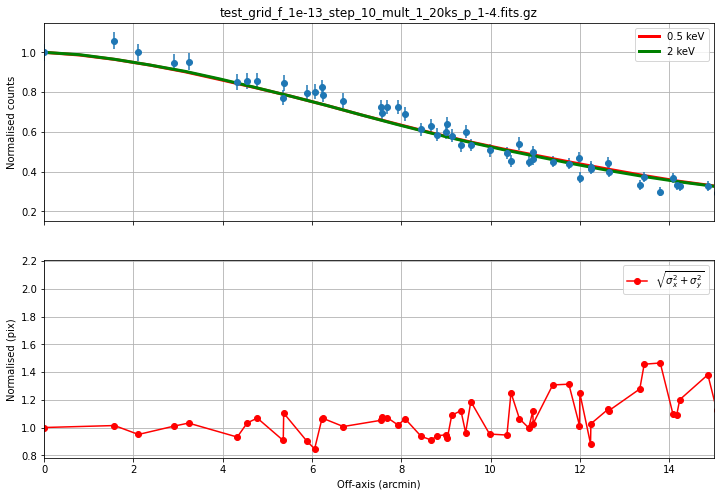

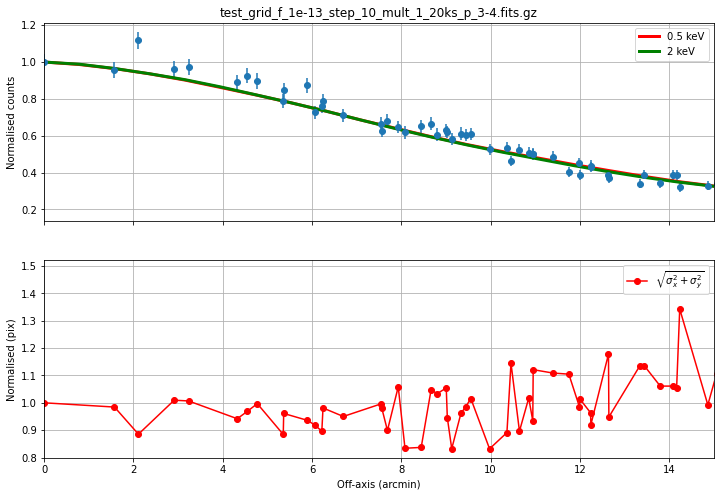

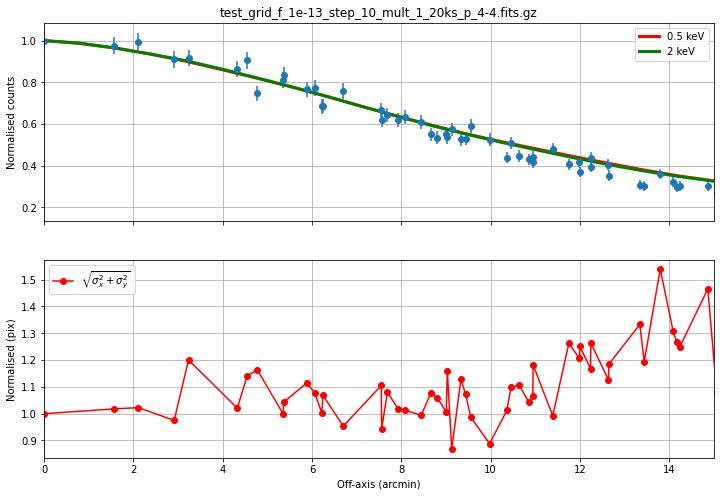

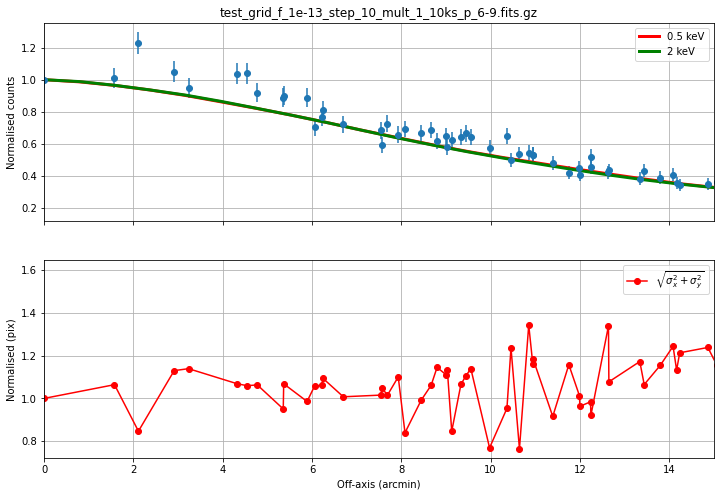

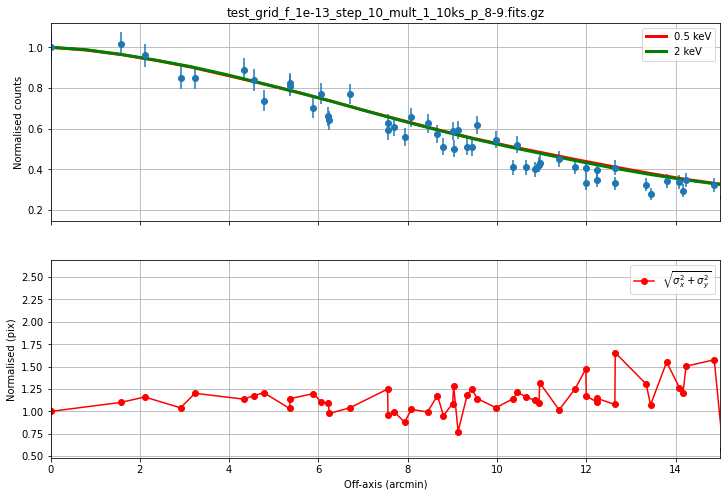

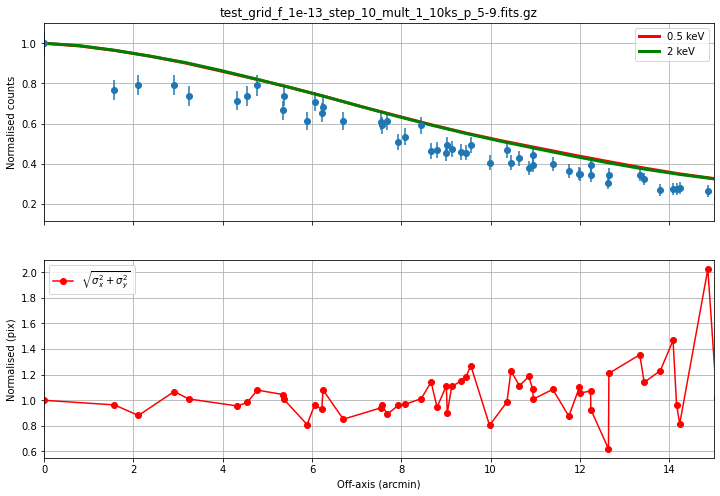

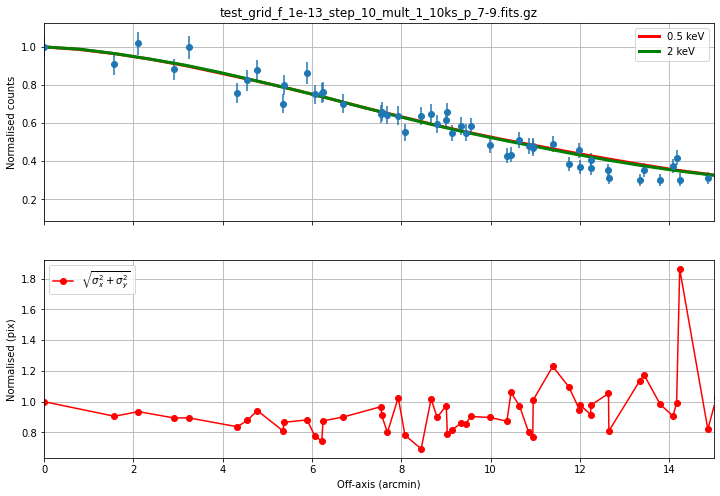

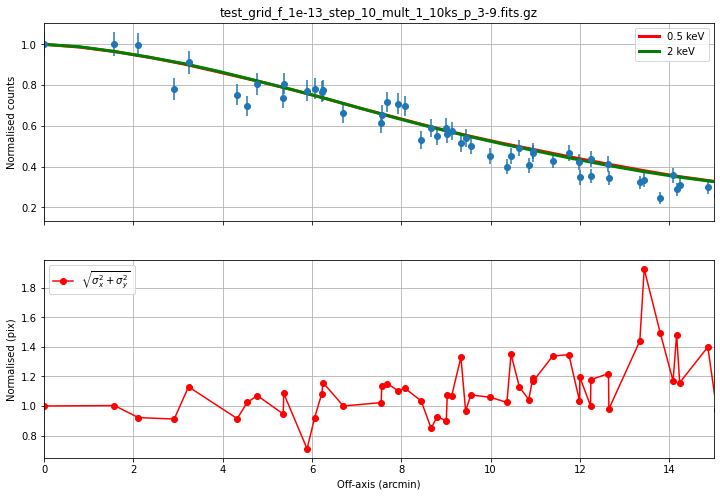

KeyboardInterrupt: 

In [25]:
for exp_n in reversed(list(np.arange(10, 110, step=10))):
    expo = str(exp_n) + "ks"
    for mag_n in [1,2,4]:
        mag = str(mag_n)+"x"
        fname = glob.glob(f'{wdir}/dev_dataset/{expo}/test_grid/{mag}/*.fits.gz')
        #fname = f'{wdir}/{expo}/test_grid/{mag}/test_grid_f_1e-13_step_10_mult_1_50ks_p_0-1.fits.gz'
        #
        for i in range(len(fname)):
        # i = 1
            bname = os.path.basename(fname[i])
            #
            # png = f'{wdir}/{os.path.splitext(bname)[0]}.png'
            png = f'{os.path.splitext(bname)[0]}.png'
            t = check_grid_sources(fname[i],reg,vtb,png)
